<a href="https://colab.research.google.com/github/Hardik-Agarwal-Github/ML-Projects/blob/main/PlantDiseaseRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model

# Importing Dataset from Kaggle

In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hardik0902","key":"d5aceaec6c89bad6a023add19c34f01d"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                 📚 Students Performance Dataset 📚                     66KB  2024-06-12 23:09:20          20896        458  1.0              
armanmanteghi/supermarket-sales-insights-and-optimization   Supermarket Sales: Insights & Optimization          741KB  2024-07-23 14:19:53           1127         29  0.9411765        
nelgiriyewithana/most-streamed-spotify-songs-2024           Most Streamed Spotify Songs 2024                    496KB  2024-06-15 18:50:51          15566        327  1.0              
ihelon/coffee-sales                                         Coffee Sales        

In [8]:
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:27<00:00, 172MB/s]
100% 2.70G/2.70G [00:27<00:00, 105MB/s]


In [ ]:
! mkdir new-plant-diseases-dataset
! unzip new-plant-diseases-dataset.zip -d new-plant-diseases-dataset

Streaming output truncated to the last 5000 lines.
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/7ee078a8-218e-4ebf-8935-ec9f844ab744___GH_HL Leaf 212.9.JPG  
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/7f58b2c9-3a62-402f-80d8-4a9aef9203ea___GH_HL Leaf 411.1.JPG  
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/7f7b6cff-3d29-45ad-a0df-56f568289be9___GH_HL Leaf 506.1.JPG  
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/806a1f93-1b9f-4860-91e1-9aff2d68c494___RS_HL 0468.JPG  
  inflating: new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/807ee562-f61

# EDA

In [ ]:
train_datagen = ImageDataGenerator(zoom_range = 0.5,shear_range = 0.3, horizontal_flip = True, preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [30]:
train = train_datagen.flow_from_directory(directory = '/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',shuffle=True, target_size = (256, 256), batch_size = 64)
val = val_datagen.flow_from_directory(directory = '/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',shuffle=True, target_size = (256, 256), batch_size = 32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [31]:
num_categories=38

In [32]:
t_img, label = train.next()
t_img.shape

(64, 256, 256, 3)

In [33]:
def plotImage(t_img, label):
  for img, l in zip(t_img, label):
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    plt.show()

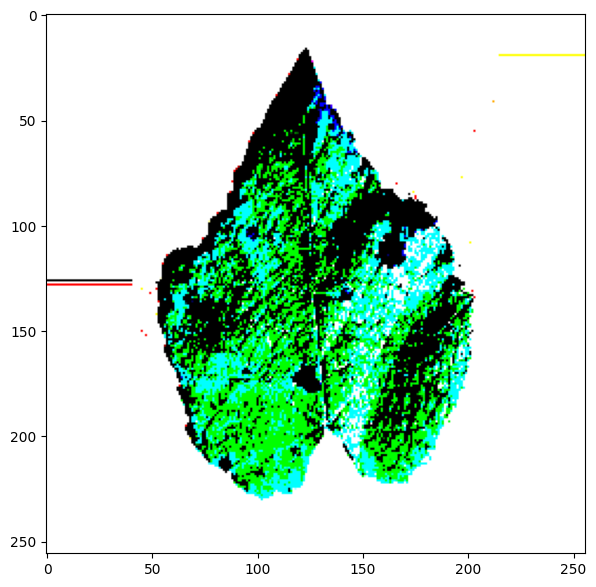

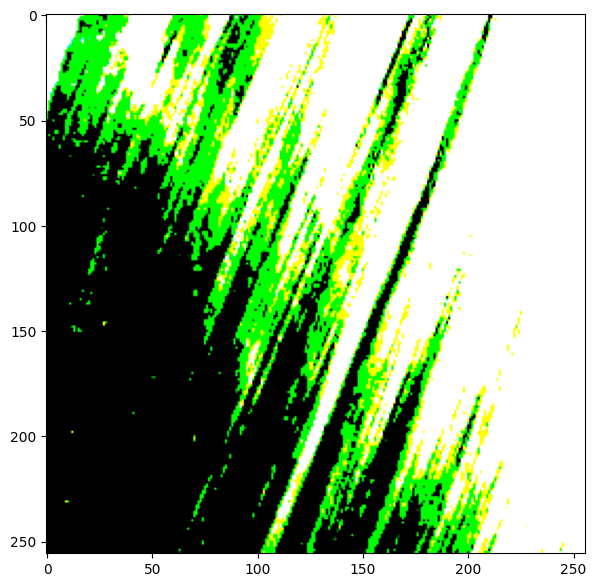

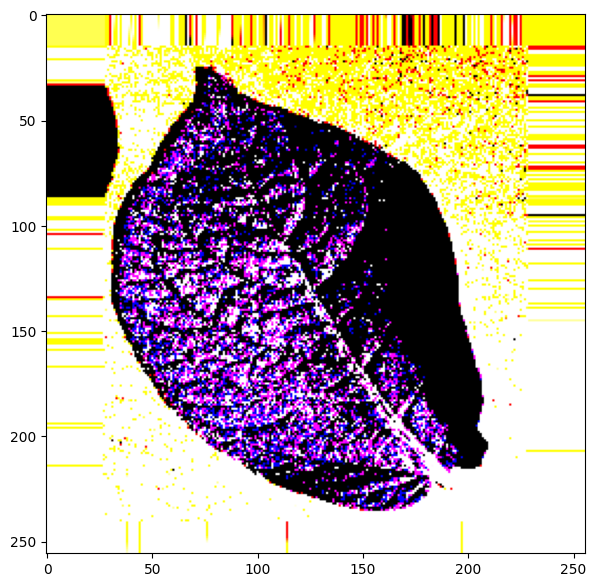

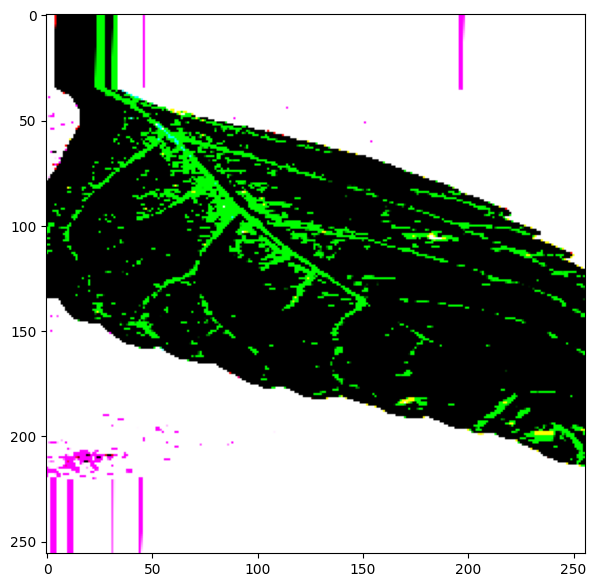

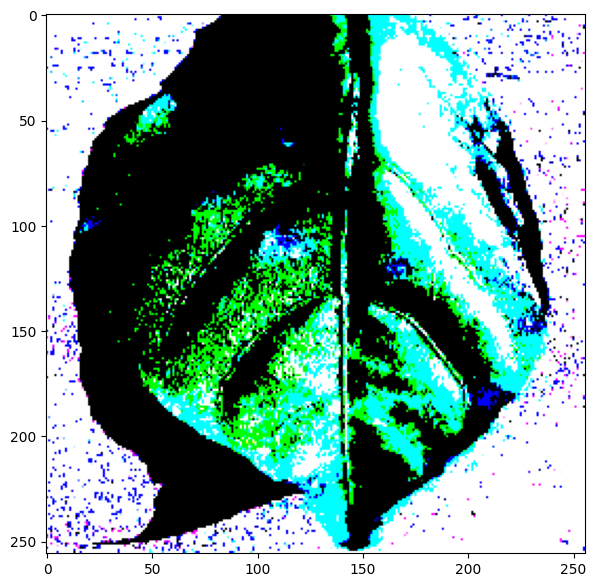

In [34]:
plotImage(t_img[:5], label[:5])

# Building Model

In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, verbose=1, patience=5)

#model checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', min_delta = 0.01,patience=5 , verbose=1, save_best_only=True)

In [40]:
cb = [es, mc]

In [36]:
base_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
base_model.trainable = False

In [37]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [48]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1028, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_categories, activation='softmax')
])

In [49]:
model.compile(optimizer='adam' , loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history = model.fit_generator(train, steps_per_epoch=32 ,epochs=50, validation_data=val, verbose=1, callbacks=cb, validation_steps=16)

<ipython-input-50-2810e89e2dda>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train, steps_per_epoch=32 ,epochs=50, validation_data=val, verbose=1, callbacks=cb, validation_steps=16)


Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 2.5836 - accuracy: 0.3921
Epoch 1: val_accuracy did not improve from 0.77930
32/32 [==============================] - 45s 1s/step - loss: 2.5836 - accuracy: 0.3921 - val_loss: 1.0347 - val_accuracy: 0.7090
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 1.0566 - accuracy: 0.6938
Epoch 2: val_accuracy did not improve from 0.77930
32/32 [==============================] - 44s 1s/step - loss: 1.0566 - accuracy: 0.6938 - val_loss: 0.7902 - val_accuracy: 0.7676
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.7626 - accuracy: 0.7695
Epoch 3: val_accuracy did not improve from 0.77930
32/32 [==============================] - 43s 1s/step - loss: 0.7626 - accuracy: 0.7695 - val_loss: 0.7155 - val_accuracy: 0.7734
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.7905
Epoch 4: val_accuracy improved from 0.77930 to 0.81445, saving model to best_model.h

# Result Analysis

In [53]:
his = history.history
his.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

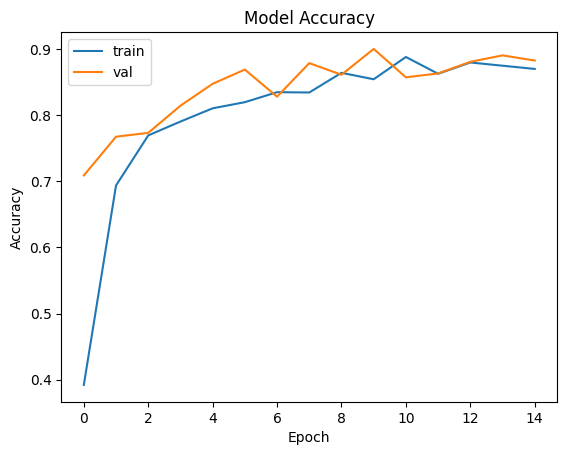

In [54]:
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

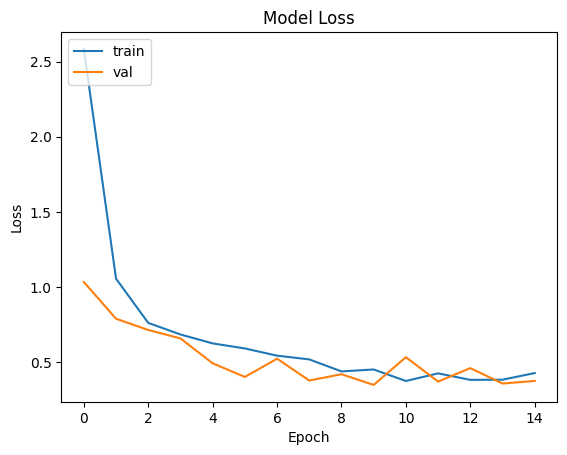

In [55]:
plt.plot(his['loss'])
plt.plot(his['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Using Best Model

In [56]:
from keras.models import load_model
model = load_model('/content/best_model.h5')

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 512)         0         
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1028)              527364    
                                                                 
 flatten_3 (Flatten)         (None, 1028)              0         
                                                                 
 dense_6 (Dense)             (None, 38)                39102     
                                                      

In [66]:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [68]:
def prediction(path):
  img = load_img(path, target_size=(256, 256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis=0)
  pred = np.argmax(model.predict(img))
  return ref[pred]

In [72]:
path = '/content/new-plant-diseases-dataset/test/test/CornCommonRust2.JPG'

result = prediction(path)
print(f"The image provided is of {result}")

1/1 [==============================] - 0s 28ms/step
The image provided is of Corn_(maize)___Common_rust_
